In [6]:
import statsmodels.api as sm
#form statsmodels.api import 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm


 
from pylab import rcParams

import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import rfpimp
from rfpimp import *

import matplotlib.pyplot as plt
import numpy as np

In [10]:
df = pd.read_csv("C:/Users/saaan/Downloads/MDA_dataframeArthur.csv", index_col='result_timestamp',parse_dates=True)
#df_nd = df.drop('result_timestamp', axis=1)
#df=df['laeq']

In [11]:
#set index frequency to every minute to prevent warning in model:
#ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
#self._init_dates(dates, freq)
#problem
#You current index, as printed, is string index. You should convert it to DatetimeIndex and pass a frequency by to_period:
#https://stackoverflow.com/questions/58510659/error-valuewarning-a-date-index-has-been-provided-but-it-has-no-associated-fr

df.index = pd.DatetimeIndex(df.index).to_period("T")
#documentation about notation of time units in to_period: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

You current index, as printed, is string index. You should convert it to DatetimeIndex and pass a frequency by to_period:

df.index = pd.DatetimeIndex(df.index).to_period('M')

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

EDA

c:\Users\saaan\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


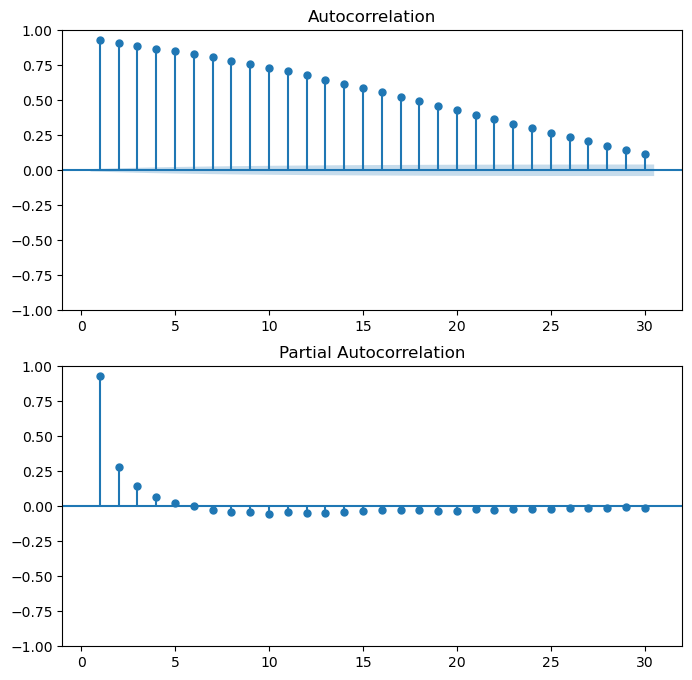

In [19]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
# Make ACF plot
plot_acf(df['laeq'], lags=30, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(df['laeq'], lags=30, zero=False, ax=ax2)
plt.show()

#acf tails off and  pacf tails off=> neither ar or ma model: look for arma model
#acf values are high and tail off very slowly=> probably data not stationary


Model selection

In [20]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(4):
  # Loop over q values from 0-2
    for q in range(4):
        #loop over d values
        for d in range(2):
          try:
            # create and fit ARMA(p,q) model
            model = ARIMA(df['laeq'], order=(p,d,q))
            results = model.fit()
        
            # Append order and results tuple
            order_aic_bic.append((p,d,q,results.aic,results.bic))

          except: 
            order_aic_bic.append((p,d,q,None,None))


c:\Users\saaan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\saaan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\saaan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\saaan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\saaan\anaconda3\lib\s

In [22]:
order_df=pd.DataFrame(order_aic_bic, columns=['p','d','q','AIC','BIC'])
print(order_df.sort_values('AIC'))
#the best model is (p,d,q)=(3,0,2)

    p  d  q            AIC            BIC
28  3  0  2  240234.035713  240296.085092
26  3  0  1  241445.094483  241498.279665
14  1  0  3  241448.724145  241501.909327
30  3  0  3  241456.554434  241527.468010
20  2  0  2  241461.346245  241514.531427
12  1  0  2  241469.237554  241513.558539
22  2  0  3  241471.389234  241533.438613
18  2  0  1  241480.885092  241525.206077
10  1  0  1  241564.938528  241600.395316
23  2  1  3  241613.206054  241666.391121
29  3  1  2  241618.270397  241671.455465
21  2  1  2  241639.429592  241683.750481
31  3  1  3  241643.163636  241705.212881
24  3  0  0  241702.257915  241746.578900
15  1  1  3  241706.207678  241750.528567
27  3  1  1  241991.071182  242035.392071
19  2  1  1  242008.132120  242043.588831
7   0  1  3  242013.835687  242049.292398
13  1  1  2  242018.030602  242053.487313
5   0  1  2  242020.814751  242047.407285
11  1  1  1  242033.684491  242060.277025
25  3  1  0  242054.490637  242089.947349
3   0  1  1  242167.635975  242185

Fit selected model

                               SARIMAX Results                                
Dep. Variable:                   laeq   No. Observations:                52271
Model:                 ARIMA(3, 0, 2)   Log Likelihood             -120110.018
Date:                Sat, 13 May 2023   AIC                         240234.036
Time:                        14:01:24   BIC                         240296.085
Sample:                    01-02-2022   HQIC                        240253.432
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.8166      0.134    378.318      0.000      50.553      51.080
ar.L1          2.1902      0.007    318.519      0.000       2.177       2.204
ar.L2         -1.4127      0.013   -104.983      0.0

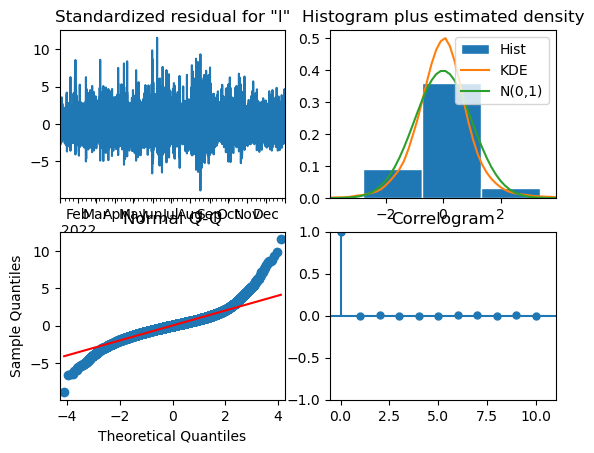

                               SARIMAX Results                                
Dep. Variable:                   laeq   No. Observations:                52271
Model:                 ARIMA(3, 0, 2)   Log Likelihood             -120110.018
Date:                Sat, 13 May 2023   AIC                         240234.036
Time:                        14:01:32   BIC                         240296.085
Sample:                    01-02-2022   HQIC                        240253.432
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.8166      0.134    378.318      0.000      50.553      51.080
ar.L1          2.1902      0.007    318.519      0.000       2.177       2.204
ar.L2         -1.4127      0.013   -104.983      0.0

In [24]:
#fit the preferred model first order=(3,0,2)
model=ARIMA(df['laeq'],order=(3,0,2))
results=model.fit()


Predictions with selected model

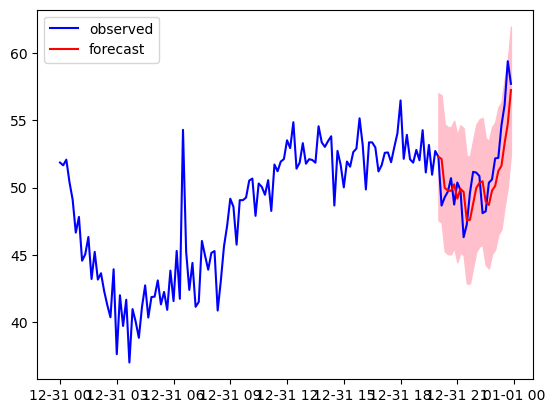

In [56]:
#evaluate predictions
forecast=results.get_prediction(start=-24)
#save forecast values
mean_forecast=forecast.predicted_mean
confidence_intervals=forecast.conf_int()
upper_limits=confidence_intervals['upper laeq']
lower_limits=confidence_intervals['lower laeq']
#for plotting the data, make a different dataframe for a few days and only including the noise variable
df_plot=df['laeq'].loc['2022-12-31']
#print(df_plot)
#indices were turned into period with the to_period() command to model the data, 
#but this cannot be used for plt, so we have to turn it into a timestamp with to_timestamp()
plt.figure()
plt.plot(df_plot.index.to_timestamp(),df_plot,color='blue', label='observed')
plt.plot(mean_forecast.index.to_timestamp(),mean_forecast.values, color='red',label='forecast')
plt.fill_between(lower_limits.index.to_timestamp(),lower_limits,upper_limits,color="pink")
plt.legend()
plt.show()

Model Diagnostics

In [ ]:
print(results.summary())

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
results.plot_diagnostics()
plt.show()
#look for normality and correlation and a pattern in upper-left corner....
#no pattern in upper-left i think; residuals not normal, resudals not correlated
print(results.summary())
#look for p(q) =residuals not correlated and p(jb)=residuals normally distributed: should both be large!!
#P(Q)=> residuals not correlated; P(JB)=residuals not normal=> problem
#=> model is a bad fit because residuals not normal

Full Box-Jenkins procedure

Sarima

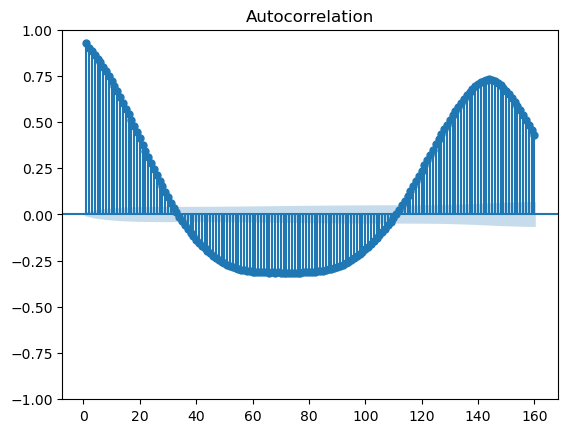

In [34]:
#Sarima
#consider detrending the data if not stationary: use rolling mean
# Subtract the rolling mean
#1 week =924 periods
df_2 = df-df.rolling(2000).mean()

# Drop the NaN values
df_2 = df_2.dropna()

# Create figure and subplots
fig, ax1 = plt.subplots()

# Plot the ACF: if you don't know how often the seasonality occurs, plot acf and look for a high correlation after a lot of low correlations
plot_acf(df_2['laeq'], lags=160, zero=False, ax=ax1)

# Show figure
plt.show()
#the correlation seems to peak every 140-145 lags=> try 144 periods=every day



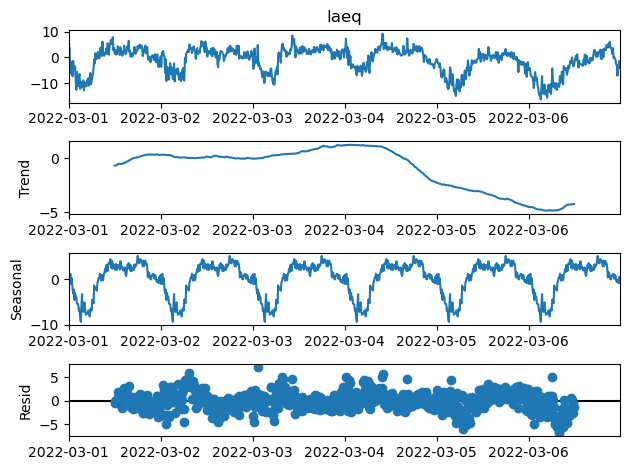

In [48]:
#let's plot the decomposition:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
#construct dataframe for only a few days
df_2.index=df_2.index.to_timestamp()
df_3=df_2.loc['2022-03-01':'2022-03-06']
# Perform additive decomposition
decomp = seasonal_decompose(df_3['laeq'], 
                            period=144)

# Plot decomposition
decomp.plot()
plt.show()


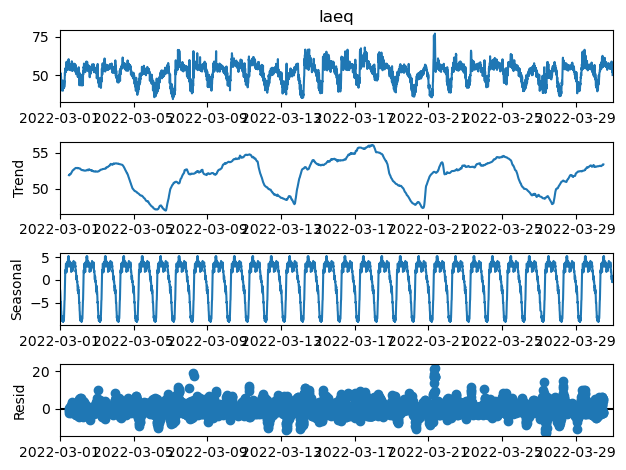

In [64]:

#without detrend
df_4=df.loc['2022-03-01':'2022-03-30']
df_4.index=df_4.index.to_timestamp()
# Perform additive decomposition
decomp = seasonal_decompose(df_4['laeq'], 
                            period=144)

# Plot decomposition
decomp.plot()
plt.show()
#after the seasonality, there is still a trend in the data, so we will have to take the difference of the arima as well

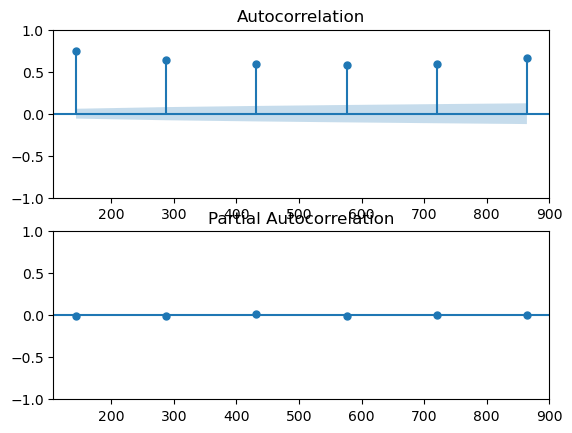

In [68]:
#finding seasonal acf and pacf
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(df['laeq'], lags=[144,288,432,576,720,864], ax=ax1)
# Plot seasonal PACF
plot_pacf(df['laeq'], lags=[144,288,432,576,720,864], ax=ax2)
plt.show()
#no apparent pattern from the data

In [ ]:
#try model selection
import pmdarima as pm
results = pm.auto_arima(df['laeq'])

In [76]:
df_5=df.loc['2022-03-01':'2022-03-30']
results = pm.auto_arima( df_5['laeq'], # data
#d=0, # non-seasonal difference order
start_p=0, # initial guess for p
start_q=0, # initial guess for q
max_p=3, # max value of p to test
max_q=3,
seasonal=True, # is the time series seasonal
m=144, # the seasonal period
D=1, # seasonal difference order
start_P=0, # initial guess for P
start_Q=0, # initial guess for Q
max_P=2, # max value of P to test
max_Q=2, # max value of Q to test
information_criterion='aic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
)
#memory issue with this model: try on smaller dataset:df_5

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[144] intercept   : AIC=25324.043, Time=205.03 sec


MemoryError: Unable to allocate 2.68 GiB for an array with shape (289, 289, 4314) and data type float64

In [12]:
#creating own automated model finder:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over q values from 0-2
    for q in range(3):
        #loop over seasonal p and q values
        for p_season in range(2):
            for q_season in range(2):
                #try:
                    # Instantiate model
                model = SARIMAX(df['laeq'], order=(p,0,q), seasonal_order=(p_season,1,q_season,144))
                # Fit model
                results = model.fit()
    
                # Append order and results tuple
                order_aic_bic.append((p,q,p_season,q_season,results.aic))

                #except: 
                   # order_aic_bic.append((p,q,p_season,q_season,None,None))



MemoryError: Unable to allocate 8.19 GiB for an array with shape (145, 145, 52272) and data type float64

In [8]:
print(order_aic_bic) 

[(0, 0, 0, 0, None, None), (0, 0, 0, 1, None, None), (0, 0, 1, 0, None, None), (0, 0, 1, 1, None, None), (0, 1, 0, 0, None, None), (0, 1, 0, 1, None, None), (0, 1, 1, 0, None, None), (0, 1, 1, 1, None, None), (0, 2, 0, 0, None, None), (0, 2, 0, 1, None, None), (0, 2, 1, 0, None, None), (0, 2, 1, 1, None, None), (1, 0, 0, 0, None, None), (1, 0, 0, 1, None, None), (1, 0, 1, 0, None, None), (1, 0, 1, 1, None, None), (1, 1, 0, 0, None, None), (1, 1, 0, 1, None, None), (1, 1, 1, 0, None, None), (1, 1, 1, 1, None, None), (1, 2, 0, 0, None, None), (1, 2, 0, 1, None, None), (1, 2, 1, 0, None, None), (1, 2, 1, 1, None, None), (2, 0, 0, 0, None, None), (2, 0, 0, 1, None, None), (2, 0, 1, 0, None, None), (2, 0, 1, 1, None, None), (2, 1, 0, 0, None, None), (2, 1, 0, 1, None, None), (2, 1, 1, 0, None, None), (2, 1, 1, 1, None, None), (2, 2, 0, 0, None, None), (2, 2, 0, 1, None, None), (2, 2, 1, 0, None, None), (2, 2, 1, 1, None, None)]


In [2]:
print(results.summary())
results.plot_diagnostics()
plt.view

NameError: name 'results' is not defined

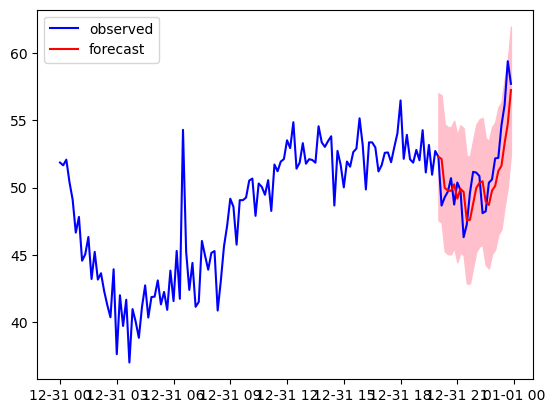

In [ ]:
#indices were turned into period with the to_period() command to model the data, 
#but this cannot be used for plt, so we have to turn it into a timestamp with to_timestamp()
plt.figure()

plt.plot(df_plot.index.to_timestamp(),df_plot,color='blue', label='observed')
plt.plot(mean_forecast.index.to_timestamp(),mean_forecast.values, color='red',label='forecast')
plt.fill_between(lower_limits.index.to_timestamp(),lower_limits,upper_limits,color="pink")
plt.legend()
plt.show()